In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta,norm
from numpy.random import default_rng
rng = default_rng()
%matplotlib inline

## generate synthetic forecast/observed data

The python function synth_data will generate sythetic forecasts (continuous/probability and binary) and observations (binary) that have some degree of correlation (rhoxf) between them and also allow the user to control the forecast bias and sharpness (distribution of the forecast values). A bivariate normal distribution is generated with specified correlation, the resulting dummy variables are used to generate observations by finding the threshold that will produce the desired base rate (xbar = mean observation), as well as using a copula approach to convert the forecasts to a beta distribution with specified alpha/beta parameters that produce the desired mean and variance (sharp * observed variance). The continuous forecast array is also thresholded to produce binary forecasts with the desired mean forecast (fbar).

python functions cont_table and cont_table_counts are discussed in intro_2x2_table.ipynb

In [2]:
def synth_data(nn,xbar,fbar,sharp,rhoxf):
    # generate synthetic binary obs with base rate = xbar
    # generate synthetic forecasts [continuous beta-distributed probability-like]
    # generate synthetic forecasts [binary with mean forecast = fbar]
    # rhoxf controls the correlation of the bivariate normal that is used to generate obs and fcst-beta
    # sharp controls the normalized sharpness in determining the beta distribution parameters of the fcsts
    cov = np.array([[1.,rhoxf ], [rhoxf,1.]])
    pts = rng.multivariate_normal([0., 0.], cov, size=nn)
    obs_bin=np.zeros_like(pts[:,0])
    xthresh=norm.ppf(1-xbar,0.,1.)
    obs_bin[pts[:,0]>=xthresh]=1.
    sx21=xbar*(1.-xbar)
    sf21=sharp*sx21
    nu1=fbar*(1-fbar)/sf21-1.
    alpha1=fbar*nu1
    beta1=(1.-fbar)*nu1
    fcst_beta=beta.ppf(norm.cdf(pts[:,1],0.,1.), alpha1,beta1)
    fthresh=np.quantile(fcst_beta,1.-fbar)
    fcst_bin=fcst_beta>=fthresh
    return obs_bin,fcst_beta,fcst_bin

def cont_table(fcst,obs):
    # assuming fcst and obs are both binary and are of the same length
    # joint probabilities elelements should sum to 1
    # return elements of 2x2 contingency table as well as a pandas dataframe for easy viewing
    nn=float(len(obs))
    aa=np.sum(obs*fcst)/nn
    bb=np.sum((1.-obs)*fcst)/nn
    cc=np.sum(obs*(1.-fcst))/nn
    dd=np.sum((1.-obs)*(1.-fcst))/nn
    df=pd.DataFrame(data=np.array([[aa,bb,aa+bb],[cc,dd,cc+dd],[aa+cc,bb+dd,aa+bb+cc+dd]]),index=['fcst=yes','fcst=no','col sum'],columns=['obs=yes','obs=no','row sum'])
    return aa, bb, cc, dd, df


## example - Finley's 1884 experimental tornado forecasts

The values in the following cell will generate a large sample of data with similar performance characteristics as Finley's 1884 tornado forecasts.

In [3]:
# these values will generate a large sample of data with similar performance characteristics as Finley's 1884 tornado forecasts
nn=100000
xbar=0.0182
fbar=0.0357
rhoxf=0.77
ratio=0.2

obs_pts,fcst_pts,fcst_bin=synth_data(nn,xbar,fbar,ratio,rhoxf)

aa, bb, cc, dd, df_tbl = cont_table(fcst_bin,obs_pts)

# multiply by 2803 to get similar total counts as Finley
print(df_tbl*2803.)

           obs=yes      obs=no    row sum
fcst=yes  28.14212    71.92498   100.0671
fcst=no   22.73233  2680.20057  2702.9329
col sum   50.87445  2752.12555  2803.0000


## discrimination diagram

Plotting the conditional forecast distributions, conditioning on the observed value ($p[f|x=0]$ and $p[f|x=1]$) is known as a discrimination diagram. A good forecast system will show large separation between conditional forecast distribution given $obs=yes$ (green histogram below) and the conditional forecast distribution given $obs=no$ (grey histogram).

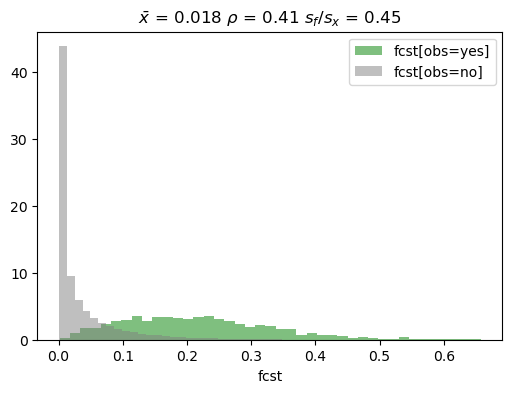

In [4]:
# plot the discrimination diagram

# calculate some stats
xbar_pts=np.mean(obs_pts)
sx2_pts=np.var(obs_pts,ddof=0)
sf2_pts=np.var(fcst_pts,ddof=0)
rho_pts=np.corrcoef([obs_pts,fcst_pts])[0][1]
sf_sx=np.sqrt(sf2_pts)/np.sqrt(sx2_pts)

# format strings containing these stats in the diagram title
leg1=r' $\rho$' + f' = {np.round(rho_pts,2)}'
sharp=r' $s_f$/$s_x$' + f' = {np.round(sf_sx,2)}'
tit1=r'$\bar x$'+f' = {np.round(xbar_pts,3)}'

fig,axs=plt.subplots(figsize=(6,4))

# obs=yes conditional distribution
axs.hist(fcst_pts[obs_pts>=0.5], bins=41,color='green',density=True,label='fcst[obs=yes]',alpha=.5)
# obs=no conditional distribution
axs.hist(fcst_pts[obs_pts<0.5], bins=41,color='gray',density=True,label='fcst[obs=no]',alpha=.5)
axs.set_title(tit1+leg1+sharp)
axs.set_xlabel('fcst')
axs.legend()

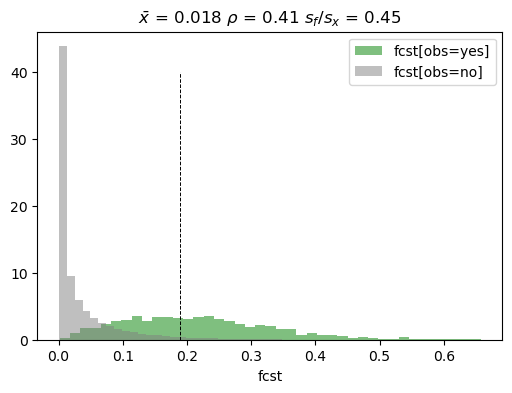

In [5]:
# include the location of the fcst threshold that was used to generate the array of binary forecasts from the continuous array

fthresh=np.quantile(fcst_pts,1.-fbar)

fig,axs=plt.subplots(figsize=(6,4))

# obs=yes conditional distribution
axs.hist(fcst_pts[obs_pts>=0.5], bins=41,color='green',density=True,label='fcst[obs=yes]',alpha=.5)
# obs=no conditional distribution
axs.hist(fcst_pts[obs_pts<0.5], bins=41,color='gray',density=True,label='fcst[obs=no]',alpha=.5)
axs.plot([fthresh,fthresh],[0,40],'k--',lw=0.7)
axs.set_title(tit1+leg1+sharp)
axs.set_xlabel('fcst')
axs.legend()

In [6]:
# print some common measures from 2x2 table, more python functions at the end of this notebook and intro_2x2_table.ipynb

def pod(a,b,c,d):
    return a/(a+c)
    
def sr(a,b,c,d):
    return a/(a+b)    

def csi(a,b,c,d):
    return a/(a+b+c)

print('POD = ',pod(aa,bb,cc,dd))
print('SR = ',sr(aa,bb,cc,dd))
print('CSI = ',csi(aa,bb,cc,dd))


POD =  0.553168044077135
SR =  0.28123249299719894
CSI =  0.22917142204976038


## generate ROC curve and performance diagram

By systematically varying the forecast threshold from low to high across the range of forecast values and generating corresponding 2x2 contingency tables, we can produce an array of measures such as POD, SR, and POFD as a function of the forecast threshold. A ROC curve is generated by plotting POD vs POFD, and a performance diagram is generated by plotting POD vs SR

In [7]:
def calc_pod_pofd_sr(fcst,obs,thresholds):
    # assuming fcst and obs are of the same length, fcst are continuous and obs are binary
    # loop over thresholds and find elements of 2x2 contingency table for each
    # calculate POD POFD SR and return these in a pandas dataframe for easy viewing
    nthresh=len(thresholds)
    pod1=np.full(nthresh,np.nan)
    pofd1=np.full(nthresh,np.nan)
    sr1=np.full(nthresh,np.nan)
    for n in np.arange(nthresh):
        fthresh=thresholds[n]
        fcst_bin=fcst>=fthresh
        nn=float(len(obs))
        aa=np.sum(obs*fcst_bin)/nn
        bb=np.sum((1.-obs)*fcst_bin)/nn
        cc=np.sum(obs*(1.-fcst_bin))/nn
        dd=np.sum((1.-obs)*(1.-fcst_bin))/nn
        pod1[n]=aa/(aa+cc)
        pofd1[n]=bb/(bb+dd)
        sr1[n]=aa/(aa+bb)
    df=pd.DataFrame(data=np.array([thresholds,pod1,sr1,pofd1]).T,columns=['thresh','POD','SR','POFD'])
    return pod1, sr1, pofd1, df

In [8]:
# set up array of thresholds going from zero to slightly above the max forecast value
# this will produce PODs that vary from 1 to 0, POFDs that vary from 1 to 0
# SR at the zero threshold will equal xbar, SR when POD=POFD=0 is undefined since a=b=0
threshs=np.quantile(fcst_pts,np.linspace(0.001,0.999,99))
threshs=np.insert(threshs,0,0.)
threshs=np.append(threshs,np.max(fcst_pts)*1.01)

# generate arrays of POD, SR, POFD corresponding with these thresholds
pod1, sr1, pofd1, df = calc_pod_pofd_sr(fcst_pts,obs_pts,threshs)
df

/tmp/ipykernel_3637363/1993627898.py:19: RuntimeWarning: invalid value encountered in scalar divide
  sr1[n]=aa/(aa+bb)


,thresh,POD,SR,POFD
0,0.000000e+00,1.000000,0.018150,1.000000
1,1.603024e-11,1.000000,0.018168,0.998982
2,3.702740e-08,1.000000,0.018355,0.988603
3,3.035665e-07,1.000000,0.018546,0.978235
4,1.124127e-06,1.000000,0.018741,0.967857
...,...,...,...,...
96,1.985366e-01,0.525069,0.301965,0.022437
97,2.279607e-01,0.426446,0.362190,0.013882
98,2.742642e-01,0.282645,0.458445,0.006172
99,4.349301e-01,0.041873,0.760000,0.000244


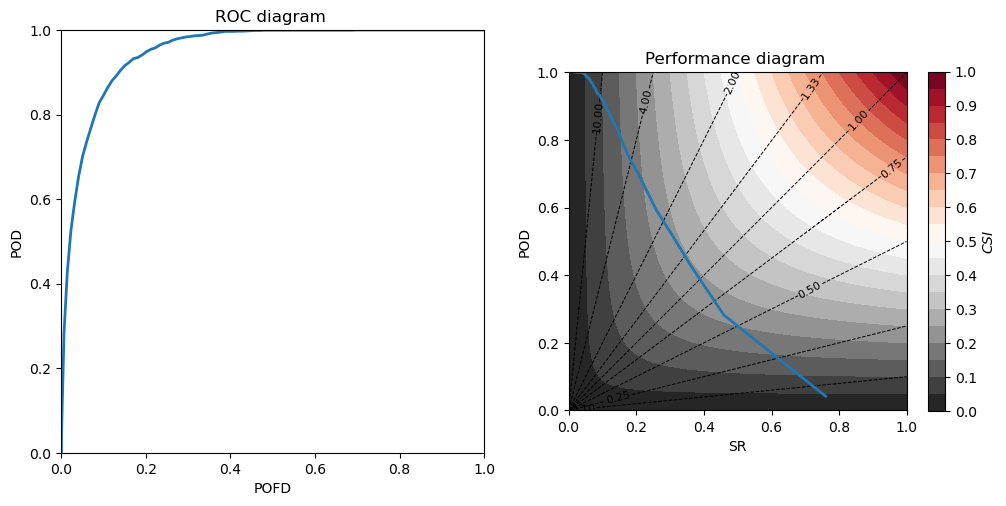

In [9]:
# create ROC and performance diagrams

xbar=0.0182

fig, axs = plt.subplots(1, 2,figsize=(12,6))
axs = axs.flat

# arrays hold 2d fields of POD, POFD, SR to allow for calculation of scores in background of plots
pod1=np.arange(0.001,1.0,0.001)
sr1=np.arange(0.001,1.0,0.001)
pofd1=np.arange(0.001,1.0,0.001)

sr2,pod2=np.meshgrid(sr1,pod1)
pofd_roc,pod_roc=np.meshgrid(pofd1,pod1)


# 2x2 contingency elements in POD,SR space
aa_r=xbar*pod2
bb_r=xbar*(pod2/sr2-pod2)
cc_r=xbar*(1.-pod2)
dd_r=1.-xbar*(pod2/sr2+1.-pod2)

# typical performance diagram will plot frequency bias and CSI in the background since these are simple functions of POD, SR
bias_roebber=pod2/sr2
plot_roebber=csi(aa_r,bb_r,cc_r,dd_r)

label1=r'$CSI$'
extend1='neither'
d_lvls=np.linspace(0.,1.,21)
d_ticks=np.linspace(0.,1.,11)

# plot performance diagram
sc1=axs[1].contourf(sr1,pod1,plot_roebber,levels=d_lvls,cmap='RdGy_r',extend=extend1)
cs0=axs[1].contour(sr1,pod1,bias_roebber,levels=np.array([0.1,0.25,0.5,0.75,1.,1.33,2.,4.,10.]),colors='k',linestyles='dashed',linewidths=0.7)
axs[1].clabel(cs0, cs0.levels, inline=True, fontsize=8)
plt.colorbar(sc1,orientation='vertical',shrink=0.735,label=label1,ax=axs[1],ticks=d_ticks)
axs[1].set_aspect('equal')
axs[1].set_ylim(0.,1.)
axs[1].set_xlim(0.,1.)
axs[1].set_xlabel('SR')
axs[1].set_ylabel('POD')
axs[1].set_title('Performance diagram ')

# plot simple ROC diagram
# 2x2 contingency elements in POD,POFD space
aa_roc=xbar*pod_roc
bb_roc=(1-xbar)*pofd_roc
cc_roc=xbar*(1.-pod_roc)
dd_roc=(1-xbar)*(1.-pofd_roc)
axs[0].set_aspect('equal')
axs[0].set_ylim(0.,1.)
axs[0].set_xlim(0.,1.)
axs[0].set_xlabel('POFD')
axs[0].set_ylabel('POD')
axs[0].set_title('ROC diagram ')


# plot results - POD vs POFD on ROC, POD vs SR on performance diagram

axs[0].plot(df.POFD,df.POD,lw=2)
axs[1].plot(df.SR,df.POD,lw=2)


In [10]:
# set up functions for score calculations from 2x2 contingency table
def ang2bias(x):
    return np.tan(x*np.pi/180.)

def bias2ang(x):
    return np.arctan(x)*180./np.pi

def pod(a,b,c,d):
    return a/(a+c)
    
def sr(a,b,c,d):
    return a/(a+b)    

def pofd(a,b,c,d):
    return b/(b+d)
    
def mr(a,b,c,d):
    return c/(c+d)

def csi(a,b,c,d):
    return a/(a+b+c)

def tversky(a,b,c,d,gamma):
    return a/(a+gamma*b+(1.-gamma)*c)
    
def pss(a,b,c,d):
    return (a*d-b*c)/(a+c)/(b+d)

def css(a,b,c,d):
    return (a*d-b*c)/(a+b)/(c+d)

def qyule(a,b,c,d):
    return (a*d-b*c)/(a*d+b*c)

def mse(a,b,c,d):
    return b+c
    
def srskill(a,b,c,d):
    return (a*d-b*c)/(a+b)/(b+d)
    
def podskill(a,b,c,d):
    return (a*d-b*c)/(a+c)/(c+d)
    
def deelia(a,b,c,d):
    return np.log(b/(a+b))/np.log(a/(a+c))

def edi(a,b,c,d):
    return (np.log(b/(b+d))-np.log(a/(a+c)))/(np.log(b/(b+d))+np.log(a/(a+c)))

def sedi(a,b,c,d):
    return (np.log(b/(b+d))-np.log(a/(a+c))-np.log(d/(b+d))+np.log(c/(a+c)))/(np.log(b/(b+d))+np.log(a/(a+c))+np.log(d/(b+d))+np.log(c/(a+c)))

def hss(a,b,c,d):
    return 2.*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d))

def kappa(a,b,c,d,w):
    return (a*d-b*c)/((1.-w)*(a+c)*(c+d)+w*(a+b)*(b+d))

def dprime(a,b,c,d):
    return norm.ppf(a/(a+c))-norm.ppf(b/(b+d))

def biasodds(a,b,c,d):
    return (a+b)*(b+d)/(a+c)/(c+d)

def oddsr(a,b,c,d):
    return a*d/b/c

def bias(a,b,c,d):
    return (a+b)/(a+c)
    
def phi(a,b,c,d):
    return (a*d-b*c)/np.sqrt((a+c)*(c+d)*(a+b)*(b+d))

def relvalue(a,b,c,d,alpha,xbar):
    if alpha>xbar:
        relval=((1.-alpha)*a-alpha*b)/(1.-alpha)/xbar
    else:
        relval=(alpha*d-(1.-alpha)*c)/alpha/(1.-xbar)
    return relval

def betafa(a,b,c,d):
    return (a/(a+c))/(b/(b+d))
    
def betame(a,b,c,d):
    return (d/(b+d))/(c/(a+c))

def alphafa(a,b,c,d):
    return (a/(a+c))/(a/(a+c)+b/(b+d))
    
def alphame(a,b,c,d):
    return (c/(a+c))/(d/(b+d)+c/(a+c))
